# Import libs

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from project_lib import Project
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2

# Data Cleansing [coursera]
In some process models Data Cleansing is a separate task, it is closely tied to Feature Creation but also draws findings from the Initial Data Exploration task. The actual data transformations are implemented in the Feature Creation asset deliverable; therefore, Data Cleansing is part of the Feature Creation task in this process model.

While tuning machine learning models, this deliverable asset is touched on a regular basis anyway because features need to be transformed to increase model performance. In such iterations, often issues with data are detected and therefore need to be corrected/addressed here as well.

The following none exhaustive list gives you some guidelines:

- Data types Are data types of columns matching their content? E.g. is age stored as integer and not as string?
- Ranges Does the value distribution of values in a column make sense? Use stats (e.g. min, max, mean, standard deviation) and visualizations (e.g. box-plot, histogram) for help
- Emptiness Are all values non-null where mandatory? E.g. client IDs
- Uniqueness Are duplicates present where undesired? E.g. client IDs
- Set memberships Are only allowed values chosen for categorical or ordinal fields? E.g. Female, Male, Unknown
- Foreign key set memberships Are only allowed values chosen as field? E.g. ZIP code
- Regular expressions Some files need to stick to a pattern expressed by a regular expression. E.g. a lower-case character followed by 6 digits
- Cross-field validation Some fields can impact validity of other fields. E.g. a male person can’t be pregnant


# Load data

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# Get the url
data_file = project.get_file("init_data.csv")
# Fetch the CSV file from the object storage using Spark
df = pd.read_csv(data_file)

# Utile Functions

In [4]:
def print_corr(df, attr):
    lb_make = LabelEncoder()
    if df[attr].dtype == 'object':
        src_enc = lb_make.fit_transform(df[attr])
    else:
        src_enc = df[attr]
    
    target_enc = lb_make.fit_transform(df['target'])
    print('Corr between', attr, 'and the target: ', np.corrcoef(src_enc, target_enc )[0][1])

def print_corr_chi(df, attr):
    lb_make = LabelEncoder()
    if df[attr].dtype == 'object':
        src_enc = lb_make.fit_transform(df[attr])
    else:
        src_enc = df[attr].values
    target_enc = lb_make.fit_transform(df['target'])
    score = chi2(src_enc.reshape(-1, 1), target_enc)[0]
    print('Corr between', attr, 'and the target: ', score[0])

# Remove Duplicated rows

In [5]:
print('Number of duplicates:', len(df[df.duplicated()]))

Number of duplicates: 29


We should delete duplicated rows because they don't add new information

In [6]:
df = df.drop_duplicates(keep = 'first')
print('Number of duplicates:', len(df[df.duplicated()]))

Number of duplicates: 0


# Clean data

## Remove extra characters and spaces

In [7]:
df['target'] = df['target'].str.replace('.', '')
df['target'].value_counts()

 <=50K    37128
 >50K     11685
Name: target, dtype: int64

In [8]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.strip()
        df[col] = df[col].str.lower()

## Cross-field validation
- a male can not be a wife
- a female can't be a husband
- a never married, divorced or widowed can't be husband or wife
- a separated person can't be wife or husband in the houshold

In [9]:
df.loc[(df['sex'] == 'female') & (df['relationship'] == 'husband'), 'relationship'] = 'wife'

In [10]:
df.loc[(df['sex'] == 'male') & (df['relationship'] == 'wife'), 'relationship'] = 'husband'

In [11]:
len(df[(df['marital_status'].isin(['never-married', 'divorced', 'widowed'])) & (df['relationship'].isin(['husband','wife']))])

0

In [12]:
len(df[(df['marital_status'].isin(['married-spouse-absent'])) & (df['relationship'].isin(['husband', 'wife']))])

0

# Feature Engineering [coursera]
Feature Creation and Feature Engineering is one of the most important tasks in machine learning since it hugely impacts model performance. This also holds for deep learning, although to a lesser extent. Features can be changed or new features can be created from existing ones

The following none exhaustive list gives you some guidelines for feature transformation:
- Imputing Some algorithms are very sensitive to missing values. Therefore, imputing allows for filling of empty fields based on its value distribution
- Imputed time-series quantization Time series often contain streams with measurements at different timestamps. Therefore, it is beneficial to quantize measurements to a common “heart beat” and impute the corresponding values. This can be done by sampling from the source time series distributions on the respective quantized time steps
- Scaling / Normalizing / Centering Some algorithms are very sensitive differences in value ranges for individual fields. Therefore, it is best practice to center data around zero and scale values to a standard deviation of one
- Filtering Sometimes imputing values doesn’t perform well, therefore deletion of low quality records is a better strategy
- Discretizing Continuous fields might confuse the model, e.g. a discrete set of age ranges sometimes performs better than continuous values, especially on smaller amounts of data and with simpler models


The following none exhaustive list gives you some guidelines for feature creation:
- One-hot-encoding Categorical integer features should be transformed into “one-hot” vectors. In relational terms this results in addition of additional columns – one columns for each distinct category
- Time-to-Frequency transformation Time-series (and sometimes also sequence data) is recorded in the time domain but can easily transformed into the frequency domain e.g. using FFT (Fast Fourier Transformation)
- Month-From-Date Creating an additional feature containing the month independent from data captures seasonal aspects. Sometimes further discretization in to quarters helps as well
- Aggregate-on-Target Simply aggregating fields the target variable (or even other fields) can improve performance, e.g. count number of data points per ZIP code or take the median of all values by geographical region

As feature engineering is an art on itself, this list cannot be exhaustive. It’s not expected to become an expert in this topic at this point. Most of it you’ll learn by practicing data science on real projects and talk to peers which might share their secrets and tricks with you.


## Fill missing values

In [13]:
for col in df.columns:
    print('There is: ', len(df[df[col] == '?']), ' missing values in ', col)

There is:  0  missing values in  age
There is:  2799  missing values in  workclass
There is:  0  missing values in  final_weight
There is:  0  missing values in  education
There is:  0  missing values in  education_duration
There is:  0  missing values in  marital_status
There is:  2809  missing values in  occupation
There is:  0  missing values in  relationship
There is:  0  missing values in  race
There is:  0  missing values in  sex
There is:  0  missing values in  capital_gain
There is:  0  missing values in  capital_loss
There is:  0  missing values in  hours_per_week
There is:  856  missing values in  native_country
There is:  0  missing values in  target


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [14]:
for col in df.columns:
    df.loc[df[col] == '?', col] = 'other'

## Add missing values feature
This feature indicates how missing values each row has

In [15]:
df['has_missing_values'] = 0
def detect_missing_value(row):
    for col in df.columns:
        if row[col] == 'other':
            row['has_missing_values'] += 1
    return row
df = df.apply(detect_missing_value, axis = 1)

In [16]:
df['has_missing_values'].value_counts()

0    44841
2     2746
1     1151
3       73
4        2
Name: has_missing_values, dtype: int64

In [17]:
print_corr_chi(df, 'has_missing_values')

Corr between has_missing_values and the target:  570.2245452953478


## drop duplicated columns

In [75]:
df = df.drop(columns = ['education_duration'])

## Combine categorical levels

### workclass

- federal-gov, local_gov, state_gov -> government
- private -> private
- self-emp-inc, self-emp-not-inc -> self-employed
- never-worked, without-pay -> unemployed
- ? -> other

In [18]:
df['com_workclass'] = df['workclass']
df.loc[df['com_workclass'].isin(['state-gov', 'federal-gov', 'local-gov']), 'com_workclass'] = 'government'
df.loc[df['com_workclass'].isin(['self-emp-inc', 'self-emp-not-inc']), 'com_workclass'] = 'self-employed'
df.loc[df['com_workclass'].isin(['without-pay', 'never-worked']), 'com_workclass'] = 'unemployed'

In [19]:
print_corr_chi(df, 'workclass')
print_corr_chi(df, 'com_workclass')

Corr between workclass and the target:  5.0402826956667e-05
Corr between com_workclass and the target:  2.011445743802379


# marital_status

 - “never-married,” “widowed,” and “divorced” ->  “single”
 - “married-civ-spouse”, “separated”, “married-af-spouse” and “married-spouse-absent” -> “married”

In [20]:
df['com_marital_status'] = df['marital_status']
df.loc[df['com_marital_status'].isin(['never-married' 'widowed', 'divorced']), 'com_marital_status'] = 'single'
df.loc[df['com_marital_status'].isin(
    ['married-civ-spouse' 'separated', 'married-af-spouse', 'married-spouse-absent']), 'com_marital_status'] = 'single'

In [21]:
print_corr_chi(df, 'marital_status')
print_corr_chi(df, 'com_marital_status')

Corr between marital_status and the target:  1678.3467045745847
Corr between com_marital_status and the target:  6744.572692797321


# native_country

In [22]:
north_america = ['united-states', 'cuba', 'jamaica', 'mexico', 'canada',
'puerto-rico', 'honduras',  'haiti', 'dominican-republic', 
'el-salvador',  'guatemala',  'outlying-us(guam-usvi-etc)',  
'trinadad&tobago', 'nicaragua',  
]

other = ['other', 'south']

asia = ['india', 'china', 'japan', 'vietnam', 'hong', 'iran', 'philippines', 'cambodia', 'thailand', 'laos', 'taiwan']

europe = ['england', 'germany', 'italy', 'poland', 'ireland', 'hungary',
'holand-netherlands', 'scotland', 'yugoslavia', 'greece', 'france', 'portugal',]

south_america = ['peru',  'columbia',  'ecuador', ]

In [23]:
df.loc[df['native_country'].isin(asia), 'com_native_country'] = 'aisa'
df.loc[df['native_country'].isin(europe), 'com_native_country'] = 'europe'
df.loc[df['native_country'].isin(north_america), 'com_native_country'] = 'north_america'
df.loc[df['native_country'].isin(south_america), 'com_native_country'] = 'south_america'
df.loc[df['native_country'].isin(other), 'com_native_country'] = 'other'

In [24]:
print_corr_chi(df, 'native_country')
print_corr_chi(df, 'com_native_country')

Corr between native_country and the target:  19.477907945569385
Corr between com_native_country and the target:  2.52509078735156


## Binning age

In [36]:
df['age_bin'] = pd.cut(df['age'], 20)

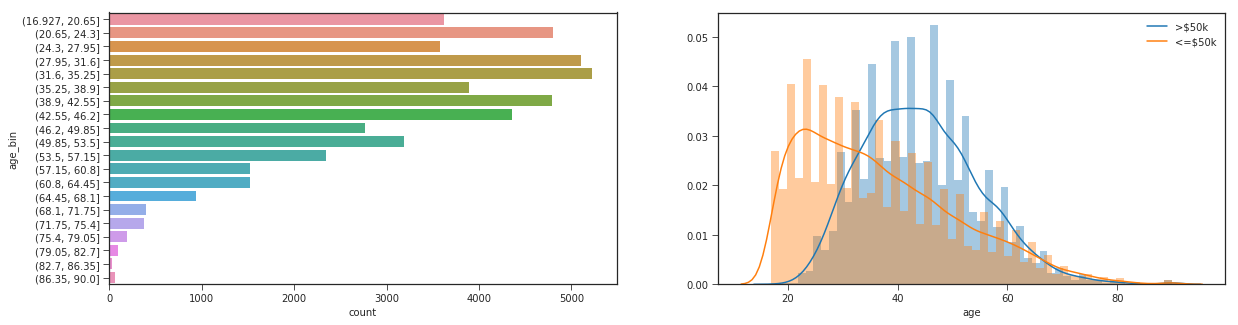

In [43]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(20, 5)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age_bin", data=df)
plt.subplot(1, 2, 2)
sns.distplot(df[df['target'] == '>50k']['age'], kde_kws={"label": ">$50k"})
sns.distplot(df[df['target'] == '<=50k']['age'], kde_kws={"label": "<=$50k"})

## Binning hours_per_week

In [45]:
df['hours_per_week_bin'] = pd.cut(df['hours_per_week'], 10)

(20, 60)

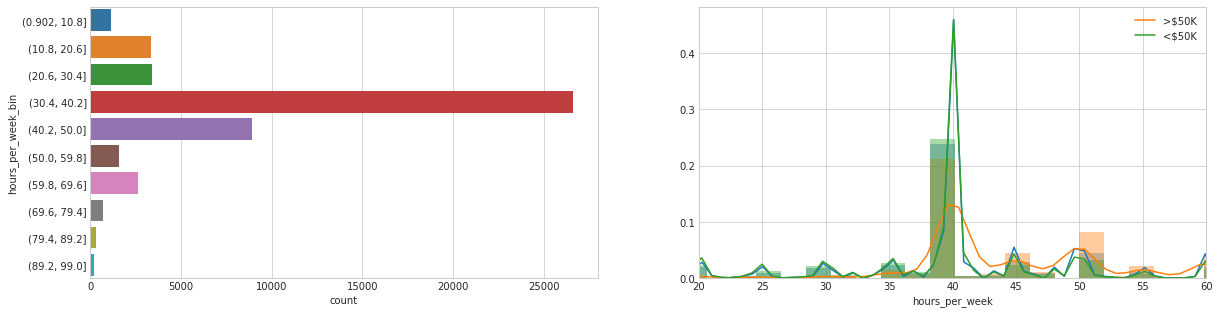

In [46]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1, 2, 1)
sns.countplot(y = "hours_per_week_bin", data = df);
plt.subplot(1, 2, 2)
sns.distplot(df['hours_per_week']);
sns.distplot(df[df['target'] == '>50k']['hours_per_week'], kde_kws={"label": ">$50K"})
sns.distplot(df[df['target'] == '<=50k']['hours_per_week'], kde_kws={"label": "<$50K"})
plt.ylim(0, None)
plt.xlim(20, 60)

## Add crossing feature: age + hours_per_work

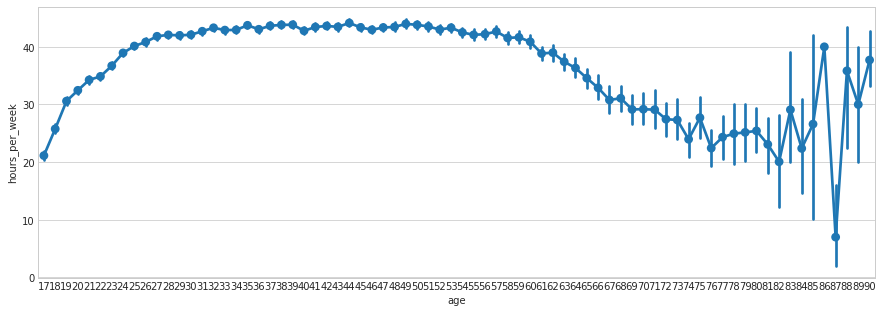

In [59]:
fig = plt.figure(figsize=(15, 5))
g = sns.pointplot(x = 'age', 
                  y = 'hours_per_week',
                  data = df,
                 )

In [61]:
# Crossing Numerical Features
df['age_hours'] = df['age'] * df['hours_per_week']
df['age_hours_bin'] = pd.cut(df['age_hours'], 10)

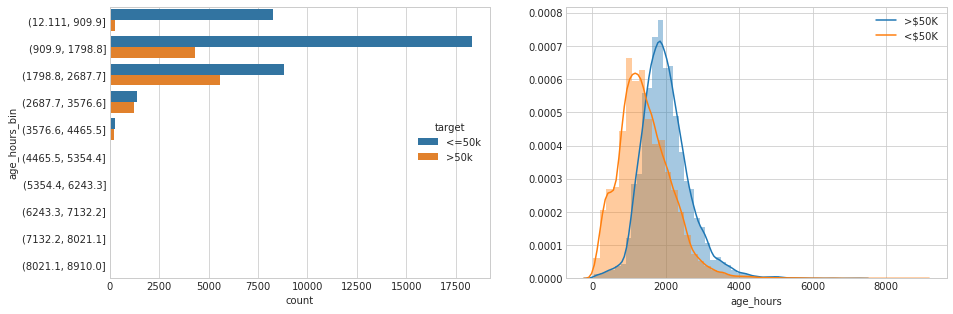

In [64]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15, 5)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age_hours_bin", data = df, hue = 'target');
plt.subplot(1, 2, 2)
sns.distplot(df[df['target'] == '>50k']['age_hours'], kde_kws={"label": ">$50K"})
sns.distplot(df[df['target'] == '<=50k']['age_hours'], kde_kws={"label": "<$50K"})

## Add feature capital_chang

In [65]:
df["capital_change"] = df["capital_gain"] - df["capital_loss"]

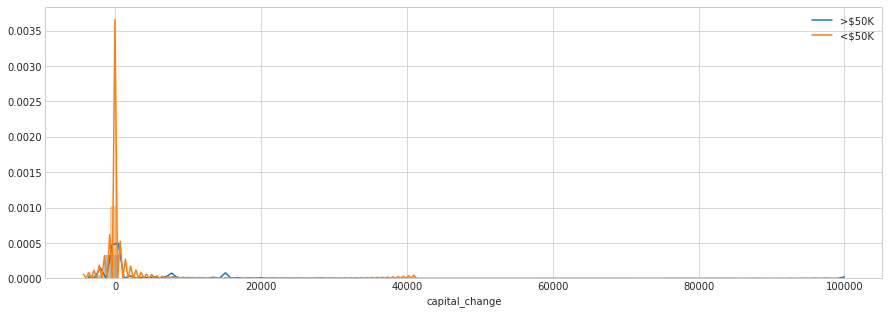

In [67]:
fig = plt.figure(figsize=(15, 5)) 
sns.distplot(df[df['target'] == '>50k']['capital_change'], kde_kws={"label": ">$50K"})
sns.distplot(df[df['target'] == '<=50k']['capital_change'], kde_kws={"label": "<$50K"})

In [68]:
df.columns

Index(['age', 'workclass', 'final_weight', 'education', 'education_duration',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'target', 'has_missing_values', 'com_workclass', 'com_marital_status',
       'com_native_country', 'age_bin', 'hours_per_week_bin', 'age_hours',
       'age_hours_bin', 'capital_change'],
      dtype='object')

# Encode categorical features

In [71]:
for col in df.columns:
    lb_enc = LabelEncoder()
    if df[col].dtype == 'object':
        df[col] = lb_enc.fit_transform(df[col])

In [74]:
df.columns

Index(['age', 'workclass', 'final_weight', 'education', 'education_duration',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'target', 'has_missing_values', 'com_workclass', 'com_marital_status',
       'com_native_country', 'age_bin', 'hours_per_week_bin', 'age_hours',
       'age_hours_bin', 'capital_change'],
      dtype='object')

# Scale continuous features

In [77]:
continuous_features = ['age', 'final_weight', 'capital_gain', 'capital_loss', 'hours_per_week', 'age_hours', 'capital_change']

In [80]:
min_max_scaler = MinMaxScaler()
df[continuous_features] = min_max_scaler.fit_transform(df[continuous_features])

# Save data

In [81]:
project.save_data("data.csv", df.to_csv(index = 0))

{'file_name': 'data.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'predictincomepotential-donotdelete-pr-tg55qtqcmgw2hz',
 'asset_id': '5de4e663-9761-4f10-827f-d8281943e026'}